## This notebook investigates the association between age and patient status for 649 COVID-19 diagnosed persons in South Korea.

### Library imports and raw data loading

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import math
import re
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/coronavirusdataset/time.csv
/kaggle/input/coronavirusdataset/patient.csv
/kaggle/input/coronavirusdataset/trend.csv
/kaggle/input/coronavirusdataset/route.csv
/kaggle/input/coronavirusdataset/group.csv


In [3]:
patient = pd.read_csv('../input/coronavirusdataset/patient.csv')

In [4]:
# convert patient state to 3 dummy variables
for value in patient['state'].unique():
  patient[str(value)] = patient['state'] == value

# get patient age
patient['age'] = 2020 - patient['birth_year']

In [5]:
patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7513 entries, 0 to 7512
Data columns (total 19 columns):
id                  7513 non-null int64
sex                 662 non-null object
birth_year          649 non-null float64
country             7513 non-null object
region              421 non-null object
disease             28 non-null float64
group               82 non-null object
infection_reason    144 non-null object
infection_order     35 non-null float64
infected_by         70 non-null float64
contact_number      50 non-null float64
confirmed_date      7513 non-null object
released_date       55 non-null object
deceased_date       36 non-null object
state               7513 non-null object
released            7513 non-null bool
isolated            7513 non-null bool
deceased            7513 non-null bool
age                 649 non-null float64
dtypes: bool(3), float64(6), int64(1), object(9)
memory usage: 961.3+ KB


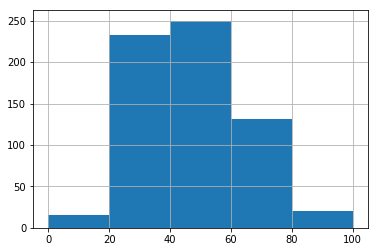

In [6]:
patient['age'].hist(bins=5, xlabelsize=10, range=(0, 100))

In [7]:
patient.pivot_table(index='state', values='id', aggfunc='count', margins=True)

,id
state,
deceased,36
isolated,7422
released,55
All,7513


* Out of 7513 verified cases, age data on only 649 is available
* Most patients are between 20 and 60 years old in this sample
* 36 patients (0.48%) have deceased as at March 8th, 2020

### Helper functions

In [8]:
def calculate_pvalues(df):
    ''' computes the p-value for each correlation'''
    df = df._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            x,y = removeMissingData(df[r],df[c])
            results = stats.pearsonr(x,y)
            pvalues[r][c] = round(results[1], 4)
    return pvalues

def removeMissingData(a, b):
    x = list(a)
    y = list(b)
    i = len(x) -1
    while(i != -1):  # get rid of missing values
        if x[i] == None or y[i] == None \
        or math.isnan(x[i]) or math.isnan(y[i]):
            del x[i]; del y[i]
        i -= 1
    return (x,y)

def graph_confidence_999(pvalues, correlations, title, row, col):
    try:
        confidence999 = pvalues.copy()
        confidence999[confidence999 > .001] = math.nan
        
        plot_df = correlations[~pd.isna(confidence999)].reindex(index = row, columns = col)
        plot_df = plot_df.dropna(axis = 'columns', how = 'all')
        plot_df = plot_df.dropna(axis = 'rows', how = 'all')
        
        f, ax = plt.subplots(figsize= (plot_df.shape[1]//0.25, plot_df.shape[0]//0.25))
        ax = sns.heatmap(plot_df, mask=None, linewidths=.1, linecolor='black', 
                         annot=True, vmin = -1, vmax = 1, cmap="Blues")

        plt.title(title, fontsize=16)
        plt.show()
    except ValueError as err:
            print(err)

### Correlations and p-values for age and patient status

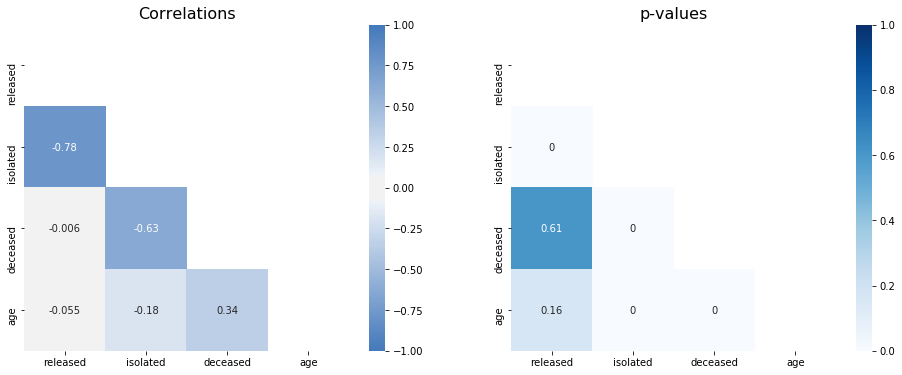

In [9]:
# correlations and p-values for age and status
df_corr = patient[['released', 'isolated', 'deceased', 'age']]
fig,ax = plt.subplots(figsize=(16, 6))
cmap = sns.diverging_palette(250, 250, sep=20, as_cmap=True)

plt.subplot(1,2,1)
correlations = df_corr.corr()
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlations, mask=mask, annot=True, vmin=-1, vmax=1, cmap=cmap)
plt.title('Correlations', fontsize=16)

plt.subplot(1,2,2)
pvalues = calculate_pvalues(df_corr).astype(float)
mask = np.zeros_like(pvalues)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(pvalues, mask=mask, annot=True, vmin=0, vmax=1, cmap="Blues")
plt.title('p-values', fontsize=16)

plt.show()

### Show only statistically significant correlations

* Age is moderately positvely correlated (rho = 0.34) to weather a patient dies or not. This means that an older person with the virus is more likely to die than a younger person with the virus.
* Age is weakly negatively correlated (rho = -0.18) to patient isolation, which implies that on average the older the patient the less likely s/he is to be isolated.
* Thess relationships are significant at the 99.9% confidence level.

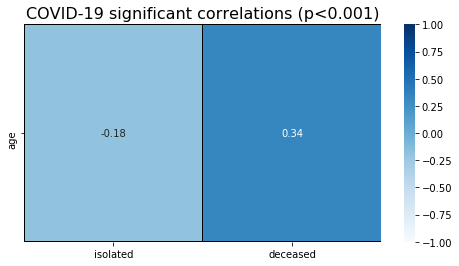

In [10]:
row = list(patient.columns)[-1:]
col = list(patient.columns)[-4:-1]
title = 'COVID-19 significant correlations (p<0.001)'
graph_confidence_999(pvalues, correlations, title, row=row, col=col)

### LogReg plots

The graph for deceased patients shows that likelihood of death starts to increase at around 50 years of age, where the slope increases till around 75 years of age where it remains constant. 

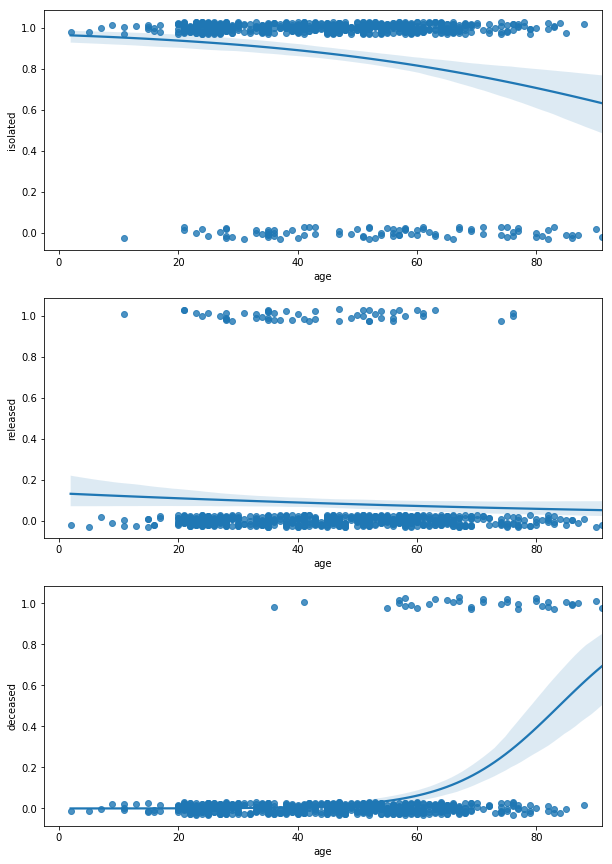

In [11]:
fig, ax = plt.subplots(figsize=(10, 15))
plt.subplot(3,1,1)
sns.regplot(x = df_corr['age'], 
            y = df_corr['isolated'], logistic=True, y_jitter=.03)

plt.subplot(3,1,2)
sns.regplot(x = df_corr['age'], 
            y = df_corr['released'], logistic=True, y_jitter=.03)

plt.subplot(3,1,3)
sns.regplot(x = df_corr['age'], 
            y = df_corr['deceased'], logistic=True, y_jitter=.03)

plt.show()